# Echo - Multi-Class Audio Classifier

This notebook implements a multi-class audio classifier using the UrbanSound8K dataset.
It uses a ResNet18 CNN model and evaluates performance using 10-fold cross-validation.

**Requirements**:
- Google Drive must contain the `UrbanSound8K` folder at `MyDrive/urbansound8k`.
- GPU Runtime is recommended.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchaudio torchvision onnxscript torchcodec

In [3]:
# Imports
import os
import glob
import shutil
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F_audio
from torchvision.models import resnet18, mobilenet_v2
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import torch.onnx


print("PyTorch Version:", torch.__version__)
print("TorchAudio Version:", torchaudio.__version__)

PyTorch Version: 2.9.0+cu126
TorchAudio Version: 2.9.0+cu126


In [ ]:
# !apt-get install tree
!tree -L 2 /content/drive/MyDrive/urbansound8k

/content/drive/MyDrive/urbansound8k
├── audio
│   ├── fold1
│   ├── fold10
│   ├── fold2
│   ├── fold3
│   ├── fold4
│   ├── fold5
│   ├── fold6
│   ├── fold7
│   ├── fold8
│   └── fold9
├── metadata
│   └── UrbanSound8K.csv
└── models
    ├── model_fold1_best.pth
    ├── model_fold2_best.pth
    ├── model_fold3_best.pth
    ├── model_fold4_best.pth
    └── model_fold5_best.pth

13 directories, 6 files


In [4]:
# Configuration & Constants
DRIVE_ROOT = "/content/drive/MyDrive/urbansound8k"
LOCAL_ROOT = '/content/UrbanSound8K_Cache'

# Set this to True to copy data to local VM (Drastically faster training)
USE_LOCAL_CACHE = True

METADATA_PATH = os.path.join(DRIVE_ROOT, 'metadata', 'UrbanSound8K.csv')
MODEL_SAVE_DIR = os.path.join(DRIVE_ROOT, 'models-new')
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

SAMPLE_RATE = 22050
DURATION = 4 # seconds
TARGET_SAMPLE_COUNT = SAMPLE_RATE * DURATION

N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048

BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 10
FOLDS = 10

CLASS_NAMES = [
    'air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling',
    'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music'
]

In [5]:
# Copy Data to Local Disk for faster access
if USE_LOCAL_CACHE:
    print("Caching data to local disk (this may take 1-2 mins but saves hours of training time)...")
    # Copy Audio folder
    if not os.path.exists(LOCAL_ROOT):
        drive_audio = os.path.join(DRIVE_ROOT, 'audio')
        local_audio = os.path.join(LOCAL_ROOT, 'audio')

        # Ensure destination exists
        if os.path.exists(drive_audio):
            shutil.copytree(drive_audio, local_audio)
            print(f"Data copied to {local_audio}")
    else:
        print("Local cache already exists.")

    DATA_ROOT = LOCAL_ROOT
else:
    DATA_ROOT = DRIVE_ROOT

AUDIO_DIR = os.path.join(DATA_ROOT, 'audio')
print(f"Using Audio Directory: {AUDIO_DIR}")

Caching data to local disk (this may take 1-2 mins but saves hours of training time)...
Data copied to /content/UrbanSound8K_Cache/audio
Using Audio Directory: /content/UrbanSound8K_Cache/audio


## Data Overview

In [6]:
metadata = pd.read_csv(METADATA_PATH)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


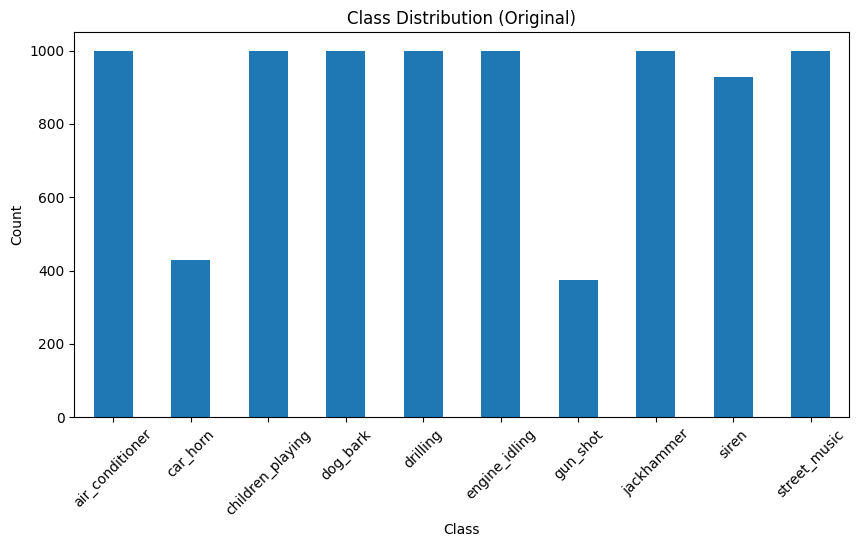

In [ ]:
# Visualize Class Distribution
plt.figure(figsize=(10, 5))
metadata['classID'].value_counts().sort_index().plot(kind='bar')
plt.title('Class Distribution (Original)')
plt.xticks(ticks=range(10), labels=CLASS_NAMES, rotation=45)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [ ]:
metadata.iloc[1]

,1
slice_file_name,100263-2-0-117.wav
fsID,100263
start,58.5
end,62.5
salience,1
fold,5
classID,2
class,children_playing


In [7]:
# Dataset Class
class UrbanSoundDataset(Dataset):
    """
    Optimized Dataset that handles loading, resampling, mixing, and padding.
    1. Loads High-Speed from Local Disk.
    2. Optionally caches loaded files in RAM (cache_to_ram=True).
    RETURNS RAW WAVEFORM (1, Length).
    """
    def __init__(self, df, cache_to_ram=True):
        """
        Args:
            df (pd.DataFrame): Dataframe containing 'slice_file_name', 'fold', 'classID'.
            audio_dir (str): Root directory with 'foldX' folders.
            target_sample_rate (int): Desired sample rate.
            num_samples (int): Fixed length for padding/truncating.
            cache_to_ram (bool): Whether to cache loaded files in RAM.
        """
        self.df = df
        self.audio_dir = AUDIO_DIR
        self.target_sample_rate = SAMPLE_RATE
        self.num_samples = TARGET_SAMPLE_COUNT
        self.cache_to_ram = cache_to_ram
        self.cache = {}

        n_rows = self.df.shape[0]

        print(f"Contains {n_rows} audio files.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        if self.cache_to_ram and index in self.cache:
            return self.cache[index]

        row = self.df.iloc[index]
        audio_path = os.path.join(self.audio_dir, f"fold{row['fold']}", row['slice_file_name'])
        label = row['classID']

        # load and pre-process(resample, convert to mono, pad) audio
        try:
            signal, sr = torchaudio.load(audio_path)

            # Resample if needed
            if sr != self.target_sample_rate:
                resampler = T.Resample(sr, self.target_sample_rate)
                signal = resampler(signal)

            # Mix down to mono if stereo
            if signal.shape[0] > 1:
                signal = torch.mean(signal, dim=0, keepdim=True)

            # Pad or Truncate
            length_signal = signal.shape[1]
            if length_signal > self.num_samples:
                signal = signal[:, :self.num_samples]
            elif length_signal < self.num_samples:
                num_missing = self.num_samples - length_signal
                signal = torch.nn.functional.pad(signal, (0, num_missing))

            result = (signal, label)

            # Cache to RAM if enabled
            if self.cache_to_ram:
                self.cache[index] = result

            return result

        except Exception as e:
            print(f"Error loading {audio_path}: {e}")
            dummy_signal = torch.zeros((1, self.num_samples))
            return dummy_signal, label

In [8]:
# Audio transform / augmentation
transform = nn.Sequential(
    T.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    ),
    T.AmplitudeToDB()
)

augment = nn.Sequential(
    T.FrequencyMasking(freq_mask_param=10),
    T.TimeMasking(time_mask_param=35)
)

In [ ]:
# create small dataset for visualization
sample_df = metadata.sample(n=2, random_state=42)
vis_ds = UrbanSoundDataset(sample_df)

## Visualize audio as spectrograms

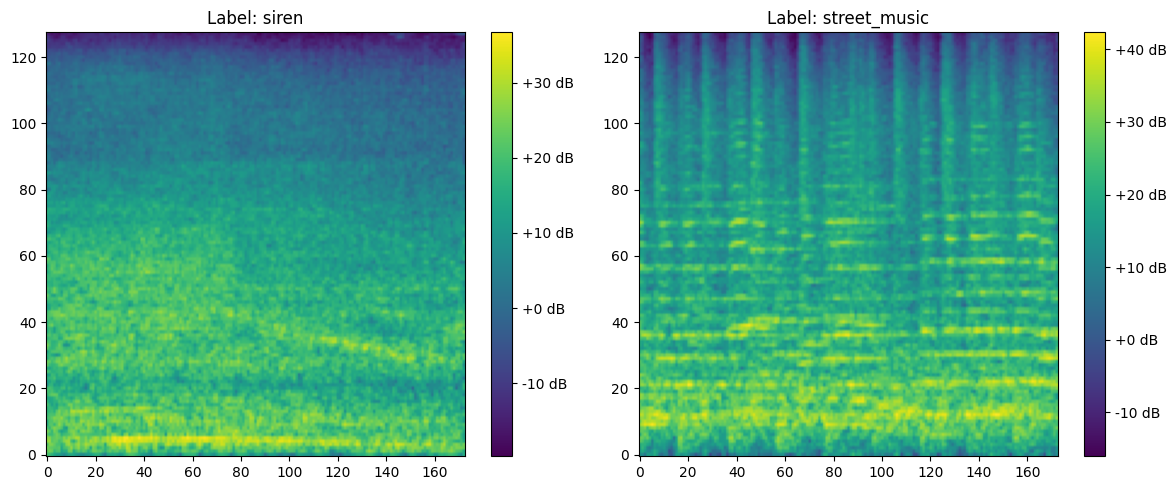

In [ ]:
# transform each example and plot
plt.figure(figsize=(12, 5))
for i in range(len(vis_ds)):
    sig, label = vis_ds[i]

    spec = transform(sig)

    plt.subplot(1, 2, i+1)
    plt.imshow(spec.squeeze().numpy(), aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"Label: {CLASS_NAMES[label]}")
    plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

## Model (Transfer Learning)

In [9]:
# Model Definition with Integrated Transforms
class AudioClassifier(nn.Module):
    """
    End-to-End Audio Classifier.
    Accepts RAW AUDIO waveforms, processes them internally, and classifies.
    """
    def __init__(self, num_classes, transform_block, augmentation_block=None):
        super().__init__()
        self.transform = transform_block
        self.augment = augmentation_block

        # edit model + add batch norm
        self.bn0 = nn.BatchNorm2d(1)
        self.model = resnet18(weights='IMAGENET1K_V1')
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        """
        transform/extract-feature -> augment (training) -> normalize -> classify
        """
        x = self.transform(x)
        x = self.bn0(x)

        if self.training and self.augment is not None:
            x = self.augment(x)

        return self.model(x)

In [10]:
# Training and Val Functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training', leave=True)
    for batch_idx, (inputs, labels) in enumerate(pbar):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # UPDATE PROGRESS BAR EVERY BATCH
        current_acc = 100. * correct / total
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc:.2f}%',
            'batch': batch_idx + 1
        })

    return running_loss / len(dataloader), correct / total

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Validation', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return running_loss / len(dataloader), accuracy, f1

## Hyperparameter Tuning (learning rate)

In [ ]:
# create data loaders
metadata_tune = pd.read_csv(METADATA_PATH)
fold_idx = 1

train_df = metadata_tune[metadata_tune['fold'] != fold_idx]
val_df = metadata_tune[metadata_tune['fold'] == fold_idx]

train_ds = UrbanSoundDataset(train_df, cache_to_ram=True)
val_ds = UrbanSoundDataset(val_df, cache_to_ram=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Contains 7859 audio files.
Contains 873 audio files.


In [ ]:
# tune learning rate with one fold combination (2-10 train, 1 val)
def tune_learning_rate(candidates):
  print(f"\n{'='*10} Tuning Learning Rate {'='*10}")
  results = {}

  for lr in candidates:
    print('-' * 50)
    print(f"Testing LR: {lr}...")
    model = AudioClassifier(NUM_CLASSES, transform, augment).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['classID']), y=train_df['classID'])
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print(f"Class Weights: {class_weights}\n")

    # Warmup cache first epoch, then fast
    best_acc = 0
    for ep in range(5):
      train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
      val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, criterion, device)
      best_acc = max(best_acc, val_acc)

      print(f"Epoch {ep+1}/5 | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")

    results[lr] = best_acc
    print(f"LR {lr} achieved Best Val Acc: {best_acc:.4f}")

  best_lr = max(results, key=results.get)
  print(f"Best Learning Rate: {best_lr}")
  return best_lr

In [ ]:
LR_CANDIDATES = [0.0001, 0.001]
BEST_LR = tune_learning_rate(LR_CANDIDATES)

#### The best learning rate is 0.0001

# Dropout Regularization

The model seems to be overfitting a bit, so let's throw in a dropout layer and see if it does better

In [14]:
# Model Definition with Integrated Transforms AND DROPOUT
class AudioClassifierDropout(nn.Module):
    """
    Our previous classifier + dropout regularization.
    """
    def __init__(self, num_classes, transform_block, augmentation_block=None, dropout_prob=0.5):
        super().__init__()
        self.transform = transform_block
        self.augment = augmentation_block


        self.bn0 = nn.BatchNorm2d(1)
        self.model = resnet18(weights='IMAGENET1K_V1')
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        x = self.transform(x)
        x = self.bn0(x)

        if self.training and self.augment is not None:
            x = self.augment(x)

        return self.model(x)

In [ ]:
# Tune Dropout Probability
def tune_dropout(dropout_candidates, lr):
    print(f"\n{'='*10} Tuning Dropout Probability {'='*10}")
    results = {}

    # Class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['classID']), y=train_df['classID'])
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # add weight decay to help w overfitting.
    for p in dropout_candidates:
        print(f"Testing Dropout p={p}...")
        model = AudioClassifierDropout(NUM_CLASSES, transform, augment, dropout_prob=p).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

        best_acc = 0
        for ep in range(3):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, criterion, device)
            best_acc = max(best_acc, val_acc)

            print(f"Epoch {ep+1}/3 | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")

        results[p] = best_acc
        print(f"Dropout {p} -> Best Val Acc: {best_acc:.4f}")

    best_p = max(results, key=results.get)
    print(f"Best Dropout Probability: {best_p}")
    return best_p

In [ ]:
DROPOUT_CANDIDATES = [0.2, 0.5, 0.7]
BEST_DROPOUT = tune_dropout(DROPOUT_CANDIDATES, lr=BEST_LR)


========== Tuning Dropout Probability ==========
Testing Dropout p=0.2...


Epoch 1/3 | Train Loss: 1.0435 Acc: 0.6307 | Val Loss: 0.9503 Acc: 0.6208 F1: 0.6447


Epoch 2/3 | Train Loss: 0.4581 Acc: 0.8347 | Val Loss: 0.8575 Acc: 0.6724 F1: 0.6807


Epoch 3/3 | Train Loss: 0.2987 Acc: 0.8973 | Val Loss: 1.1196 Acc: 0.6667 F1: 0.6884
Dropout 0.2 -> Best Val Acc: 0.6724
Testing Dropout p=0.5...


Epoch 1/3 | Train Loss: 1.1036 Acc: 0.6080 | Val Loss: 0.7368 Acc: 0.7113 F1: 0.7325


Epoch 2/3 | Train Loss: 0.4697 Acc: 0.8342 | Val Loss: 0.9184 Acc: 0.6816 F1: 0.6922


Epoch 3/3 | Train Loss: 0.3141 Acc: 0.8902 | Val Loss: 0.9692 Acc: 0.6873 F1: 0.7006
Dropout 0.5 -> Best Val Acc: 0.7113
Testing Dropout p=0.7...


Epoch 1/3 | Train Loss: 1.3762 Acc: 0.5202 | Val Loss: 0.8046 Acc: 0.7297 F1: 0.7468


Epoch 2/3 | Train Loss: 0.6427 Acc: 0.7736 | Val Loss: 0.8148 Acc: 0.7446 F1: 0.7546


Epoch 3/3 | Train Loss: 0.4415 Acc: 0.8467 | Val Loss: 0.9953 Acc: 0.7125 F1: 0.7358
Dropout 0.7 -> Best Val Acc: 0.7446
Best Dropout Probability: 0.7


best dropout probability (p) is 0.7

# Final Training Loop (early stopping + checkpointing)
Combine Dropout(p=0.7) and LR=0.0001 with weight decay to run the complete 10 folds and save the best model.

In [12]:
# declaring vars on second run
BEST_LR = 0.0001
BEST_DROPOUT = 0.7

In [15]:
# Main Loop (10-Fold CV)
print(f"starting Full Training with LR: {BEST_LR} and Dropout(p={BEST_DROPOUT})...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fold_accuracies = []
fold_f1s = []

for fold in range(1, FOLDS + 1):
    print(f"\n{'='*20} Fold {fold}/{FOLDS} {'='*20}")

    train_df = metadata[metadata['fold'] != fold]
    val_df = metadata[metadata['fold'] == fold]

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['classID']), y=train_df['classID'])
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Dataset yields Raw Audio
    train_ds = UrbanSoundDataset(train_df)
    val_ds = UrbanSoundDataset(val_df)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # Initialize Model with nn.Sequential blocks
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AudioClassifierDropout(NUM_CLASSES, transform, augment, BEST_DROPOUT).to(device)
    optimizer = optim.Adam(model.parameters(), lr=BEST_LR, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    best_val_acc = 0.0
    best_val_f1 = 0.0

    # stop training if no improvement is noticed after 3 epochs
    patience_counter = 0
    early_stopping_patience = 3

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")

        # if there's an improvement, reset counter and save checkpoint
        if val_f1 > best_val_f1:
          best_val_acc = val_acc
          best_val_f1 = val_f1
          patience_counter = 0

          save_path = os.path.join(MODEL_SAVE_DIR, f'model_fold{fold}_best.pth')
          torch.save(model.state_dict(), save_path)
        else:
          patience_counter += 1

        # early stopping
        if patience_counter >= early_stopping_patience:
            break


    fold_accuracies.append(best_val_acc)
    fold_f1s.append(best_val_f1)
    print(f"--> Best Validation F1 for Fold {fold}: {best_val_f1:.4f} | Saved to {save_path}")

    # MEMORY CLEANUP
    del model
    torch.cuda.empty_cache()

print("\n" + "*"*30)
print("FINAL RESULTS ACROSS 10 FOLDS")
print("*"*30)
print(f"Average Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Average F1 Score: {np.mean(fold_f1s):.4f}")

starting Full Training with LR: 0.0001 and Dropout(p=0.7)...

==================== Fold 1/10 ====================
Contains 7859 audio files.
Contains 873 audio files.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


Epoch 1/10 | Train Loss: 1.4265 Acc: 0.5025 | Val Loss: 0.9896 Acc: 0.6552 F1: 0.6620


Epoch 2/10 | Train Loss: 0.6491 Acc: 0.7731 | Val Loss: 1.0005 Acc: 0.6861 F1: 0.6882


Epoch 3/10 | Train Loss: 0.4295 Acc: 0.8557 | Val Loss: 1.3268 Acc: 0.6804 F1: 0.6918


Epoch 4/10 | Train Loss: 0.3326 Acc: 0.8911 | Val Loss: 1.7081 Acc: 0.6174 F1: 0.6278


Epoch 5/10 | Train Loss: 0.2575 Acc: 0.9118 | Val Loss: 1.2123 Acc: 0.6907 F1: 0.7175


Epoch 6/10 | Train Loss: 0.2073 Acc: 0.9265 | Val Loss: 1.2281 Acc: 0.7022 F1: 0.7354


Epoch 7/10 | Train Loss: 0.1659 Acc: 0.9435 | Val Loss: 1.5049 Acc: 0.6861 F1: 0.7143


Epoch 8/10 | Train Loss: 0.1412 Acc: 0.9510 | Val Loss: 1.9659 Acc: 0.6186 F1: 0.6374


Epoch 9/10 | Train Loss: 0.1319 Acc: 0.9564 | Val Loss: 1.3199 Acc: 0.7457 F1: 0.7685


Epoch 10/10 | Train Loss: 0.1090 Acc: 0.9639 | Val Loss: 1.4191 Acc: 0.7010 F1: 0.6972
--> Best Validation F1 for Fold 1: 0.7685 | Saved to /content/drive/MyDrive/urbansound8k/models-new/model_fold1_best.pth

==================== Fold 2/10 ====================
Contains 7844 audio files.
Contains 888 audio files.


Epoch 1/10 | Train Loss: 1.3220 Acc: 0.5381 | Val Loss: 0.8689 Acc: 0.6881 F1: 0.6955


Epoch 2/10 | Train Loss: 0.5991 Acc: 0.7927 | Val Loss: 0.9134 Acc: 0.6982 F1: 0.7170


Epoch 3/10 | Train Loss: 0.4064 Acc: 0.8660 | Val Loss: 0.9110 Acc: 0.7128 F1: 0.7269


Epoch 4/10 | Train Loss: 0.2939 Acc: 0.8956 | Val Loss: 0.9665 Acc: 0.7354 F1: 0.7465


Epoch 5/10 | Train Loss: 0.2260 Acc: 0.9235 | Val Loss: 0.7441 Acc: 0.7568 F1: 0.7671


Epoch 6/10 | Train Loss: 0.2040 Acc: 0.9380 | Val Loss: 0.9574 Acc: 0.8074 F1: 0.8182


Epoch 7/10 | Train Loss: 0.1623 Acc: 0.9440 | Val Loss: 0.9009 Acc: 0.7815 F1: 0.7836


Epoch 8/10 | Train Loss: 0.1498 Acc: 0.9512 | Val Loss: 0.7982 Acc: 0.7500 F1: 0.7563


Epoch 9/10 | Train Loss: 0.1262 Acc: 0.9581 | Val Loss: 0.9093 Acc: 0.7815 F1: 0.7894
--> Best Validation F1 for Fold 2: 0.8182 | Saved to /content/drive/MyDrive/urbansound8k/models-new/model_fold2_best.pth

==================== Fold 3/10 ====================
Contains 7807 audio files.
Contains 925 audio files.


Epoch 1/10 | Train Loss: 1.3836 Acc: 0.5208 | Val Loss: 1.0840 Acc: 0.6497 F1: 0.6762


Epoch 2/10 | Train Loss: 0.6433 Acc: 0.7794 | Val Loss: 1.3147 Acc: 0.6454 F1: 0.6771


Epoch 3/10 | Train Loss: 0.4181 Acc: 0.8508 | Val Loss: 1.0703 Acc: 0.6886 F1: 0.7199


Epoch 4/10 | Train Loss: 0.3083 Acc: 0.8988 | Val Loss: 1.0750 Acc: 0.6908 F1: 0.7129


Epoch 5/10 | Train Loss: 0.2395 Acc: 0.9141 | Val Loss: 1.3429 Acc: 0.6703 F1: 0.7014


Epoch 6/10 | Train Loss: 0.2104 Acc: 0.9296 | Val Loss: 1.4353 Acc: 0.6508 F1: 0.6934
--> Best Validation F1 for Fold 3: 0.7199 | Saved to /content/drive/MyDrive/urbansound8k/models-new/model_fold3_best.pth

==================== Fold 4/10 ====================
Contains 7742 audio files.
Contains 990 audio files.


Epoch 1/10 | Train Loss: 1.3817 Acc: 0.5044 | Val Loss: 0.8629 Acc: 0.7010 F1: 0.7034


Epoch 2/10 | Train Loss: 0.6379 Acc: 0.7768 | Val Loss: 0.8639 Acc: 0.7222 F1: 0.7295


Epoch 3/10 | Train Loss: 0.4176 Acc: 0.8535 | Val Loss: 0.6685 Acc: 0.7828 F1: 0.7780


Epoch 4/10 | Train Loss: 0.3127 Acc: 0.8924 | Val Loss: 0.6818 Acc: 0.7758 F1: 0.7821


Epoch 5/10 | Train Loss: 0.2516 Acc: 0.9129 | Val Loss: 0.7105 Acc: 0.7677 F1: 0.7749


Epoch 6/10 | Train Loss: 0.1992 Acc: 0.9313 | Val Loss: 0.8309 Acc: 0.7576 F1: 0.7555


Epoch 7/10 | Train Loss: 0.1653 Acc: 0.9443 | Val Loss: 0.6358 Acc: 0.8030 F1: 0.8049


Epoch 8/10 | Train Loss: 0.1335 Acc: 0.9547 | Val Loss: 0.7843 Acc: 0.7788 F1: 0.7726


Epoch 9/10 | Train Loss: 0.1135 Acc: 0.9602 | Val Loss: 0.6850 Acc: 0.8313 F1: 0.8244


Epoch 10/10 | Train Loss: 0.1177 Acc: 0.9614 | Val Loss: 0.7975 Acc: 0.7838 F1: 0.7932
--> Best Validation F1 for Fold 4: 0.8244 | Saved to /content/drive/MyDrive/urbansound8k/models-new/model_fold4_best.pth

==================== Fold 5/10 ====================
Contains 7796 audio files.
Contains 936 audio files.


Epoch 1/10 | Train Loss: 1.3751 Acc: 0.5296 | Val Loss: 0.6984 Acc: 0.7521 F1: 0.7439


Epoch 2/10 | Train Loss: 0.6102 Acc: 0.7886 | Val Loss: 0.6795 Acc: 0.7618 F1: 0.7575


Epoch 3/10 | Train Loss: 0.3998 Acc: 0.8606 | Val Loss: 0.6038 Acc: 0.8056 F1: 0.8131


Epoch 4/10 | Train Loss: 0.3033 Acc: 0.8946 | Val Loss: 0.3816 Acc: 0.8718 F1: 0.8718


Epoch 5/10 | Train Loss: 0.2192 Acc: 0.9227 | Val Loss: 0.5429 Acc: 0.8387 F1: 0.8393


Epoch 6/10 | Train Loss: 0.1991 Acc: 0.9341 | Val Loss: 0.4306 Acc: 0.8483 F1: 0.8525


Epoch 7/10 | Train Loss: 0.1615 Acc: 0.9428 | Val Loss: 0.4874 Acc: 0.8558 F1: 0.8578
--> Best Validation F1 for Fold 5: 0.8718 | Saved to /content/drive/MyDrive/urbansound8k/models-new/model_fold5_best.pth

==================== Fold 6/10 ====================
Contains 7909 audio files.
Contains 823 audio files.


Epoch 1/10 | Train Loss: 1.3158 Acc: 0.5395 | Val Loss: 1.0640 Acc: 0.6513 F1: 0.6557


Epoch 2/10 | Train Loss: 0.6080 Acc: 0.7938 | Val Loss: 1.0966 Acc: 0.7157 F1: 0.7270


Epoch 3/10 | Train Loss: 0.4025 Acc: 0.8636 | Val Loss: 1.1040 Acc: 0.7497 F1: 0.7746


Epoch 4/10 | Train Loss: 0.2955 Acc: 0.8987 | Val Loss: 1.0627 Acc: 0.7509 F1: 0.7681


Epoch 5/10 | Train Loss: 0.2455 Acc: 0.9152 | Val Loss: 0.8827 Acc: 0.7679 F1: 0.7797


Epoch 6/10 | Train Loss: 0.2082 Acc: 0.9313 | Val Loss: 0.8860 Acc: 0.7716 F1: 0.7916


Epoch 7/10 | Train Loss: 0.1613 Acc: 0.9463 | Val Loss: 1.1381 Acc: 0.7339 F1: 0.7619


Epoch 8/10 | Train Loss: 0.1310 Acc: 0.9571 | Val Loss: 1.0271 Acc: 0.7594 F1: 0.7830


Epoch 9/10 | Train Loss: 0.1489 Acc: 0.9530 | Val Loss: 1.2140 Acc: 0.7643 F1: 0.7852
--> Best Validation F1 for Fold 6: 0.7916 | Saved to /content/drive/MyDrive/urbansound8k/models-new/model_fold6_best.pth

==================== Fold 7/10 ====================
Contains 7894 audio files.
Contains 838 audio files.


Epoch 1/10 | Train Loss: 1.3097 Acc: 0.5339 | Val Loss: 0.9805 Acc: 0.6659 F1: 0.6579


Epoch 2/10 | Train Loss: 0.5767 Acc: 0.8009 | Val Loss: 1.1742 Acc: 0.6504 F1: 0.6570


Epoch 3/10 | Train Loss: 0.3601 Acc: 0.8753 | Val Loss: 1.1644 Acc: 0.7148 F1: 0.7058


Epoch 4/10 | Train Loss: 0.2812 Acc: 0.9087 | Val Loss: 1.4496 Acc: 0.7076 F1: 0.6969


Epoch 5/10 | Train Loss: 0.2082 Acc: 0.9270 | Val Loss: 1.0380 Acc: 0.7625 F1: 0.7586


Epoch 6/10 | Train Loss: 0.1748 Acc: 0.9389 | Val Loss: 1.3238 Acc: 0.6647 F1: 0.6730


Epoch 7/10 | Train Loss: 0.1579 Acc: 0.9448 | Val Loss: 1.3387 Acc: 0.7041 F1: 0.7111


Epoch 8/10 | Train Loss: 0.1219 Acc: 0.9593 | Val Loss: 1.0336 Acc: 0.7697 F1: 0.7710


Epoch 9/10 | Train Loss: 0.1207 Acc: 0.9605 | Val Loss: 1.0213 Acc: 0.7160 F1: 0.7278


Epoch 10/10 | Train Loss: 0.0944 Acc: 0.9700 | Val Loss: 1.0293 Acc: 0.7220 F1: 0.7166
--> Best Validation F1 for Fold 7: 0.7710 | Saved to /content/drive/MyDrive/urbansound8k/models-new/model_fold7_best.pth

==================== Fold 8/10 ====================
Contains 7926 audio files.
Contains 806 audio files.


Epoch 1/10 | Train Loss: 1.3340 Acc: 0.5315 | Val Loss: 1.3138 Acc: 0.6576 F1: 0.6726


Epoch 2/10 | Train Loss: 0.5988 Acc: 0.7906 | Val Loss: 1.1220 Acc: 0.7035 F1: 0.7154


Epoch 3/10 | Train Loss: 0.3874 Acc: 0.8641 | Val Loss: 1.3030 Acc: 0.6712 F1: 0.6886


Epoch 4/10 | Train Loss: 0.3076 Acc: 0.8940 | Val Loss: 1.2943 Acc: 0.7072 F1: 0.7244


Epoch 5/10 | Train Loss: 0.2169 Acc: 0.9239 | Val Loss: 1.2120 Acc: 0.7010 F1: 0.6935


Epoch 6/10 | Train Loss: 0.1937 Acc: 0.9316 | Val Loss: 1.2885 Acc: 0.7171 F1: 0.7291


Epoch 7/10 | Train Loss: 0.1446 Acc: 0.9510 | Val Loss: 1.1827 Acc: 0.7680 F1: 0.7785


Epoch 8/10 | Train Loss: 0.1349 Acc: 0.9553 | Val Loss: 1.6990 Acc: 0.6216 F1: 0.6292


Epoch 9/10 | Train Loss: 0.1172 Acc: 0.9605 | Val Loss: 1.5582 Acc: 0.6998 F1: 0.7210


Epoch 10/10 | Train Loss: 0.1177 Acc: 0.9600 | Val Loss: 1.0731 Acc: 0.7184 F1: 0.7244
--> Best Validation F1 for Fold 8: 0.7785 | Saved to /content/drive/MyDrive/urbansound8k/models-new/model_fold8_best.pth

==================== Fold 9/10 ====================
Contains 7916 audio files.
Contains 816 audio files.


Epoch 1/10 | Train Loss: 1.4099 Acc: 0.5116 | Val Loss: 0.7806 Acc: 0.7684 F1: 0.7771


Epoch 2/10 | Train Loss: 0.6370 Acc: 0.7807 | Val Loss: 0.8623 Acc: 0.7328 F1: 0.7467


Epoch 3/10 | Train Loss: 0.4267 Acc: 0.8566 | Val Loss: 0.5772 Acc: 0.8211 F1: 0.8338


Epoch 4/10 | Train Loss: 0.3055 Acc: 0.8963 | Val Loss: 0.7716 Acc: 0.8088 F1: 0.8178


Epoch 5/10 | Train Loss: 0.2437 Acc: 0.9166 | Val Loss: 0.7413 Acc: 0.8211 F1: 0.8359


Epoch 6/10 | Train Loss: 0.2086 Acc: 0.9301 | Val Loss: 0.7220 Acc: 0.8174 F1: 0.8309


Epoch 7/10 | Train Loss: 0.1628 Acc: 0.9438 | Val Loss: 0.7956 Acc: 0.8125 F1: 0.8298


Epoch 8/10 | Train Loss: 0.1319 Acc: 0.9573 | Val Loss: 0.8214 Acc: 0.7917 F1: 0.8127
--> Best Validation F1 for Fold 9: 0.8359 | Saved to /content/drive/MyDrive/urbansound8k/models-new/model_fold9_best.pth

==================== Fold 10/10 ====================
Contains 7895 audio files.
Contains 837 audio files.


Epoch 1/10 | Train Loss: 1.3689 Acc: 0.5322 | Val Loss: 0.9228 Acc: 0.6487 F1: 0.6609


Epoch 2/10 | Train Loss: 0.6515 Acc: 0.7744 | Val Loss: 0.7445 Acc: 0.7145 F1: 0.7352


Epoch 3/10 | Train Loss: 0.3885 Acc: 0.8676 | Val Loss: 0.7894 Acc: 0.7360 F1: 0.7572


Epoch 4/10 | Train Loss: 0.2887 Acc: 0.8988 | Val Loss: 0.7128 Acc: 0.7622 F1: 0.7834


Epoch 5/10 | Train Loss: 0.2232 Acc: 0.9254 | Val Loss: 0.8218 Acc: 0.7587 F1: 0.7780


Epoch 6/10 | Train Loss: 0.1890 Acc: 0.9336 | Val Loss: 0.6229 Acc: 0.8005 F1: 0.8155


Epoch 7/10 | Train Loss: 0.1639 Acc: 0.9454 | Val Loss: 0.7878 Acc: 0.7945 F1: 0.8157


Epoch 8/10 | Train Loss: 0.1417 Acc: 0.9511 | Val Loss: 0.7515 Acc: 0.8053 F1: 0.8216


Epoch 9/10 | Train Loss: 0.1298 Acc: 0.9548 | Val Loss: 0.7544 Acc: 0.7861 F1: 0.8045


Epoch 10/10 | Train Loss: 0.1077 Acc: 0.9661 | Val Loss: 0.6970 Acc: 0.8124 F1: 0.8219
--> Best Validation F1 for Fold 10: 0.8219 | Saved to /content/drive/MyDrive/urbansound8k/models-new/model_fold10_best.pth

******************************
FINAL RESULTS ACROSS 10 FOLDS
******************************
Average Accuracy: 0.7888
Average F1 Score: 0.8002


In [21]:
# going with fold 4's model as it achieved the lowest loss and consistent downtrend
pth_path = "/content/drive/MyDrive/urbansound8k/models-new/model_fold5_best.pth"
onnx_path = os.path.join(MODEL_SAVE_DIR,'sentinel_audio_clf.onnx')

In [22]:
# Export Model to ONNX
def export_onnx_direct(pth_path, save_path):
  # reconstruct model class to load state dict
  device = torch.device('cpu')
  model = AudioClassifierDropout(
        num_classes=NUM_CLASSES,
        transform_block=transform,
        augmentation_block=None,
        dropout_prob=BEST_DROPOUT
  )
  model.to(device)

  # load saved weights
  state_dict = torch.load(pth_path, map_location=device)
  model.load_state_dict(state_dict)

  # set model mode
  model.cpu()
  model.eval()

  # Dummy input: Raw Audio (Batch, 1, Samples)
  dummy_input = torch.randn(1, 1, TARGET_SAMPLE_COUNT).to(device)

  # export
  torch.onnx.export(
      model,
      dummy_input,
      save_path,
      export_params=True,
      opset_version=17,
      do_constant_folding=True,
      input_names=['waveform'],
      output_names=['class_logits'],
      dynamic_axes={'waveform': {0: 'batch_size', 2: 'samples'}, 'class_logits': {0: 'batch_size'}}
  )
  print(f"End-to-End Model successfully exported to {save_path}")

In [25]:
# Verify the function
export_onnx_direct(pth_path, onnx_path)

/tmp/ipython-input-2644603354.py:25: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0121 16:44:32.384000 441 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 17 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `AudioClassifierDropout([...]` with `torch.export.export(..., strict=False)`...


W0121 16:44:36.085000 441 torch/fx/experimental/symbolic_shapes.py:6833] _maybe_guard_rel() was called on non-relation expression Eq(8200*(s77 - 1)*Max(1, ((s53//512)) + 1) + 8200*((s53//512)) + 8200, 0) | (8200*(s77 - 1)*Max(1, ((s53//512)) + 1) + 8200*((s53//512)) + 8200 <= 8200*s77*(((s53//512)) + 1))


[torch.onnx] Obtain model graph for `AudioClassifierDropout([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


W0121 16:44:47.961000 441 torch/fx/experimental/symbolic_shapes.py:6833] _maybe_guard_rel() was called on non-relation expression Eq(8200*(s77 - 1)*Max(1, ((s53//(512*s77))) + 1) + 8200*((s53//(512*s77))) + 8200, 0) | (8200*(s77 - 1)*Max(1, ((s53//(512*s77))) + 1) + 8200*((s53//(512*s77))) + 8200 <= 8200*s77*(((s53//(512*s77))) + 1))


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/BaseConverter.h:65: adapter_lookup: Assertion `false`

[torch.onnx] Translate the graph into ONNX... ✅
Applied 46 of general pattern rewrite rules.
End-to-End Model successfully exported to /content/drive/MyDrive/urbansound8k/models-new/sentinel_audio_clf.onnx


In [27]:
import onnx
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("✅ Export successful and verified!")

✅ Export successful and verified!
